## Convert text to different languages and use text to speech for dialogue.

-- pip install everything you don't have


-- you need a .env file that has openai = YOURKEY

In [23]:
from pathlib import Path
from openai import OpenAI
import os
import pandas as pd


from dotenv import load_dotenv

import warnings
warnings.filterwarnings("ignore")


load_dotenv()

client = OpenAI(api_key=os.getenv("openai"))

### Pick voices for characters

In [24]:
# Create a map of your characters to their voices
voices = ["alloy", "echo", "fable", "onyx", "nova", "shimmer"]

voice_map = {'Player':'onyx',
             'NPC':'shimmer',
            'Narrator':'onyx'}

## Import your exported conversations. I used Dialogue for Unity
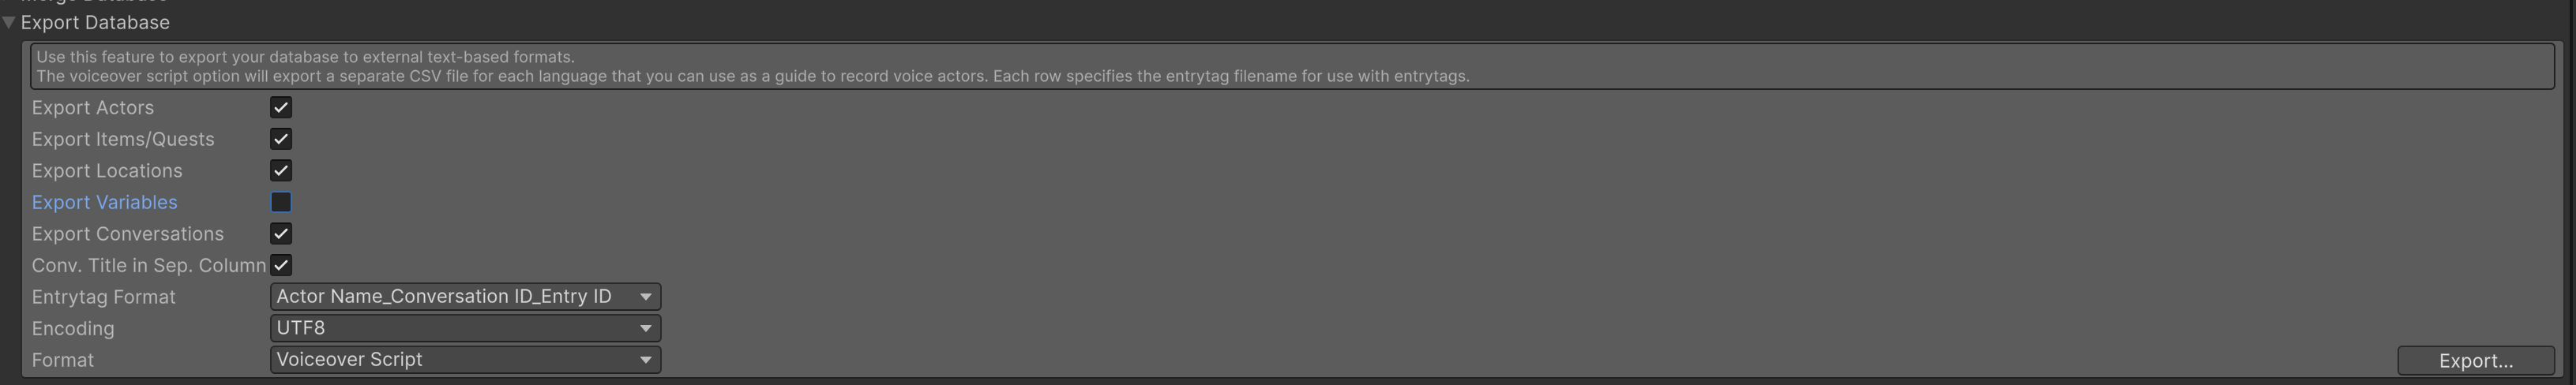

In [25]:
conv = 'example.csv' #exported from Dialogue for Unity, feel free to make your own parser. All my conversations begin with V_

script_data_df = pd.read_csv(conv, skiprows=14)
tts_df = script_data_df[script_data_df['Conversation'].astype(str).str.startswith('V_')]
#Print unique actors
print(f"Actors: {tts_df['Actor'].unique()}")
tts_df.loc[:, 'voice'] = tts_df['Actor'].map(voice_map)

display(tts_df)

Actors: ['NPC' 'Player']


,entrytag,Actor,Conversation,Description,Dialogue Text,voice
0,NPC_1_1,NPC,V_Morning,NaN,"Hello, are you awake?",shimmer
1,Player_1_2,Player,V_Morning,NaN,NO!,onyx
5,Player_2_1,Player,V_Meeting,NaN,I am going to have to get to my meeting soon.,onyx
6,NPC_2_4,NPC,V_Meeting,NaN,"Hey all, lets do a quick sync this morning!",shimmer
7,Player_2_5,Player,V_Meeting,NaN,"The meeting can wait for a few minutes, I need...",onyx
8,Player_2_6,Player,V_Meeting,NaN,Sheesh...,onyx


## Translator converts dialogue text to any language

In [26]:
# Define a translator function that uses OpenAI Chat API to translate text to the target language
def translator(user_input, target_language, model="gpt-3.5-turbo-1106"):
    # Define the prompt for the translation task
    prompt = [
        {
            "role": "system",
            "content": f"You are the language model. Your task is to detect the language of the given text and translate it to {target_language}."
        },
        {
            "role": "user",
            "content": f'Translate the following text to {target_language}: "{user_input}". This is localization for a video game, so make sure it is of the highest quality. Only return the translated text and nothing extra. Do not acknowledge the user input in any way. It must be the {target_language} translation of the text only.'
        }
    ]
        
    # Use the OpenAI Chat API to generate the translation
    resp = client.chat.completions.create(model=model, temperature=0, messages=prompt)
    
    # Return the translated text
    return resp.choices[0].message.content


In [27]:
translator("I love you", "French")

"Je t'aime"

In [28]:
tts_df['Dialogue Text_l'] = tts_df['Dialogue Text'].apply(lambda x: translator(x, 'Japanese'))

display(tts_df)

,entrytag,Actor,Conversation,Description,Dialogue Text,voice,Dialogue Text_l
0,NPC_1_1,NPC,V_Morning,NaN,"Hello, are you awake?",shimmer,こんにちは、起きていますか？
1,Player_1_2,Player,V_Morning,NaN,NO!,onyx,いいえ！
5,Player_2_1,Player,V_Meeting,NaN,I am going to have to get to my meeting soon.,onyx,私はもうすぐ会議に行かなければなりません。
6,NPC_2_4,NPC,V_Meeting,NaN,"Hey all, lets do a quick sync this morning!",shimmer,みなさん、今朝は素早く同期しましょう！
7,Player_2_5,Player,V_Meeting,NaN,"The meeting can wait for a few minutes, I need...",onyx,会議は数分待ってもらえますか、私は犬をなでる必要があります。
8,Player_2_6,Player,V_Meeting,NaN,Sheesh...,onyx,うわー...


## Create Text to Speech that is realistic with OpenAI TTS

In [17]:
# Define a function to generate voice audio files for each dialogue text
def get_voice(df, conversation_col='Conversation', voice='voice', dialog_col='Dialogue Text', file_name='entrytag', folder='Voice'):
    # Create folders for each Conversation
    unique_conversations = df[conversation_col].unique()
    print(unique_conversations)
    # Create folders for each conversation
    for conversation in unique_conversations:
        Path(f'audio/{folder}/{conversation}/Resources').mkdir(parents=True, exist_ok=True)

    # Use TTS to generate audio for each dialogue text, using the correct voice based on the actor
    for index, row in df.iterrows():
        save_folder = f'audio/{folder}/{row[conversation_col]}/Resources/{row[file_name]}.mp3'
        response = client.audio.speech.create(model="tts-1", voice=row[voice], input=row[dialog_col])
        response.stream_to_file(save_folder)

In [18]:
#Generate Audio
get_voice(tts_df)

['V_Morning' 'V_Meeting']


### Generate Localised Audio

In [21]:
# Use the Japanese column this time. It is called Dialogue Text_l
display(tts_df)

,entrytag,Actor,Conversation,Description,Dialogue Text,voice,Dialogue Text_l
0,NPC_1_1,NPC,V_Morning,NaN,"Hello, are you awake?",shimmer,こんにちは、起きていますか？
1,Player_1_2,Player,V_Morning,NaN,NO!,onyx,いいえ！
5,Player_2_1,Player,V_Meeting,NaN,I am going to have to get to my meeting soon.,onyx,私はもうすぐ会議に行かなければなりません。
6,NPC_2_4,NPC,V_Meeting,NaN,"Hey all, lets do a quick sync this morning!",shimmer,みなさん、今朝は素早く同期しましょう！
7,Player_2_5,Player,V_Meeting,NaN,"The meeting can wait for a few minutes, I need...",onyx,会議は数分待ってもらえますか、私は犬をなでる必要があります。
8,Player_2_6,Player,V_Meeting,NaN,Sheesh...,onyx,うわー...


In [22]:
get_voice(tts_df, dialog_col='Dialogue Text_l', folder='Voice_Japanese')

['V_Morning' 'V_Meeting']


### Nice, you can now localise both text and audio